In [2]:
%cd supervised-learning-IsmiRosiaDwianti

/content/supervised-learning-IsmiRosiaDwianti


In [3]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train.csv


In [4]:
import pandas as pd

# Membaca dataset (delimiter default: koma)
df = pd.read_csv('train.csv')

# Cek ringkasan awal dataset
print("\n🔍 Ringkasan Data:")
df.info()

# Statistik deskriptif untuk kolom numerik
numerical_df = df.select_dtypes(include='number')

# Hitung statistik
stats = numerical_df.describe().T
stats['median'] = numerical_df.median()
stats['Q1'] = numerical_df.quantile(0.25)
stats['Q2'] = numerical_df.quantile(0.5)
stats['Q3'] = numerical_df.quantile(0.75)
stats['missing'] = df[numerical_df.columns].isnull().sum()
stats['total_data'] = len(df)

# Tampilkan hasil statistik deskriptif
print("\n📊 Statistik Deskriptif Lengkap:")
print(stats[['count', 'mean', 'median', 'std', 'min', 'Q1', 'Q2', 'Q3', 'max', 'missing', 'total_data']])

# Cek fitur yang memiliki nilai hilang
print("\n⚠️ Fitur dengan Missing Values:")
missing_stats = stats[stats['missing'] > 0][['missing']]
if not missing_stats.empty:
    print(missing_stats)
else:
    print("Tidak ada fitur numerik dengan missing value.")



🔍 Ringkasan Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   in

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- Load dataset
df = pd.read_csv('train.csv')

# --- Label Encoding untuk kolom kategorikal
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# --- Pisahkan fitur dan target
X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']

# --- Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
train_combined = pd.concat([X_train, y_train], axis=1)
train_combined['split'] = 'train'

test_combined = pd.concat([X_test, y_test], axis=1)
test_combined['split'] = 'test'

final_data = pd.concat([train_combined, test_combined], axis=0)
final_data.to_csv('data_processing.csv', index=False)

print("Data Processing Selesai")


Data Processing Selesai


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load data dari file hasil preprocessing sebelumnya ---
df_encoded = pd.read_csv('data_processing.csv')

df_encoded = df_encoded[df_encoded['split'] == 'train'].drop(columns=['split'])

# --- 2. Ambil kolom numerik saja ---
df_numerik = df_encoded.select_dtypes(include=[np.number])

# --- 3. Fungsi untuk menghapus outlier berdasarkan IQR ---
def remove_outliers_iqr(df):
    df_clean = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# --- 4. Hapus outlier ---
df_no_outliers = remove_outliers_iqr(df_encoded)
df_no_outliers_numerik = df_no_outliers.select_dtypes(include=[np.number])

# --- 5. Simpan hasil setelah outlier handling ---
df_no_outliers.to_csv('outlier_handling.csv', index=False)

def save_boxplots_grid(df, title, filename):
    n_cols = 3
    n_rows = int(np.ceil(len(df.columns) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    fig.suptitle(title, fontsize=18)

    for i, col in enumerate(df.columns):
        row = i // n_cols
        col_pos = i % n_cols
        ax = axes[row][col_pos] if n_rows > 1 else axes[col_pos]
        sns.boxplot(x=df[col], ax=ax, color="skyblue")
        ax.set_title(f"Boxplot: {col}", fontsize=12)

        # Tambahkan batas bawah dan atas
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        ax.axvline(x=lower, color='r', linestyle='--', label='Lower Bound')
        ax.axvline(x=upper, color='r', linestyle='--', label='Upper Bound')
        ax.legend()

    for j in range(i + 1, n_rows * n_cols):
        row = j // n_cols
        col_pos = j % n_cols
        ax = axes[row][col_pos] if n_rows > 1 else axes[col_pos]
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(filename)
    plt.close()

# ---Simpan visualisasi boxplot ---
save_boxplots_grid(df_numerik,
                   title="Boxplot Semua Fitur (Sebelum Outlier Removal)",
                   filename="boxplot_with_outlier.png")

save_boxplots_grid(df_no_outliers_numerik,
                   title="Boxplot Semua Fitur (Setelah Outlier Removal)",
                   filename="boxplot_tanpa_outlier.png")




In [28]:
!git add knn_k7.png
!git commit -m “Visualisasi_knn_K7”
!git push origin main

[main 2850c31] “Visualisasi_knn_K7”
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 knn_k7.png
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 22.73 KiB | 22.73 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/IET-Polinela/supervised-learning-IsmiRosiaDwianti.git
   5df1286..2850c31  main -> main


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/My Drive/Colab Notebooks/Lab4_23758014.ipynb" "/content/[REPOSITORY]/"


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os

# Load dataset tanpa outlier
df = pd.read_csv("outlier_handling.csv")

# Ambil hanya kolom numerik
df_numerik = df.select_dtypes(include=[np.number])

# Scaling
scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()

df_standard_scaled = pd.DataFrame(scaler_std.fit_transform(df_numerik), columns=df_numerik.columns)
df_minmax_scaled = pd.DataFrame(scaler_minmax.fit_transform(df_numerik), columns=df_numerik.columns)

# Simpan hasil scaling
df_standard_scaled.to_csv("feature_scaling.csv", index=False)

fitur_terpilih = df_numerik.columns  # semua fitur

n = len(fitur_terpilih)
plt.figure(figsize=(20, n * 3.5))  # tinggi dinamis

for i, col in enumerate(fitur_terpilih):
    # Histogram Data Asli
    plt.subplot(n, 3, i * 3 + 1)
    sns.histplot(df_numerik[col], kde=True, color='skyblue')
    plt.title(f'{col} - Asli')

    # Histogram StandardScaler
    plt.subplot(n, 3, i * 3 + 2)
    sns.histplot(df_standard_scaled[col], kde=True, color='orange')
    plt.title(f'{col} - StandardScaler')

    # Histogram MinMaxScaler
    plt.subplot(n, 3, i * 3 + 3)
    sns.histplot(df_minmax_scaled[col], kde=True, color='green')
    plt.title(f'{col} - MinMaxScaler')

plt.tight_layout()
plt.savefig("feature_scaling.png")
plt.close()

print("Histogram scaling berhasil disimpan")


Histogram scaling berhasil disimpan


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==== Dataset 1: Dengan outlier ====
df_raw = pd.read_csv("train.csv")
df_raw_num = df_raw.select_dtypes(include=[np.number]).dropna()

X_raw = df_raw_num.drop("SalePrice", axis=1)
y_raw = df_raw_num["SalePrice"]

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

lr_raw = LinearRegression()
lr_raw.fit(X_train_raw, y_train_raw)
y_pred_raw = lr_raw.predict(X_test_raw)

mse_raw = mean_squared_error(y_test_raw, y_pred_raw)
r2_raw = r2_score(y_test_raw, y_pred_raw)

# ==== Dataset 2: Tanpa outlier + Scaling ====
df_clean = pd.read_csv("feature_scaling.csv")
df_clean_num = df_clean.select_dtypes(include=[np.number]).dropna()

X_clean = df_clean_num.drop("SalePrice", axis=1)
y_clean = df_clean_num["SalePrice"]

scaler = StandardScaler()
X_clean_scaled = scaler.fit_transform(X_clean)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean_scaled, y_clean, test_size=0.2, random_state=42)

lr_clean = LinearRegression()
lr_clean.fit(X_train_clean, y_train_clean)
y_pred_clean = lr_clean.predict(X_test_clean)

mse_clean = mean_squared_error(y_test_clean, y_pred_clean)
r2_clean = r2_score(y_test_clean, y_pred_clean)

# ==== Fungsi visualisasi dan simpan sebagai PNG ====
def simpan_visualisasi(y_test, y_pred, judul_prefix, filename, mse, r2):
    residuals = y_test - y_pred

    print(f"[{judul_prefix}]")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.4f}\n")

    plt.figure(figsize=(18, 5))

    # 1. Scatter plot Prediksi vs Aktual
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel("Aktual")
    plt.ylabel("Prediksi")
    plt.title(f"{judul_prefix} - Prediksi vs Aktual")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

    # 2. Residual plot
    plt.subplot(1, 3, 2)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Prediksi")
    plt.ylabel("Residual")
    plt.title(f"{judul_prefix} - Residual Plot")

    # 3. Distribusi residual
    plt.subplot(1, 3, 3)
    sns.histplot(residuals, kde=True, color='purple')
    plt.title(f"{judul_prefix} - Distribusi Residual")

    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Simpan dan tampilkan visualisasi + MSE + R2
simpan_visualisasi(y_test_raw, y_pred_raw, "Dengan Outlier", "LinearRegression_Dengan_Outlier.png", mse_raw, r2_raw)
simpan_visualisasi(y_test_clean, y_pred_clean, "Tanpa Outlier + Scaling", "LinearRegression_Tanpa_Outlier_Scaling.png", mse_clean, r2_clean)


[Dengan Outlier]
MSE: 1591724600.58
R2 Score: 0.7982

[Tanpa Outlier + Scaling]
MSE: 0.30
R2 Score: 0.5362



Polynomial Regression Degree 2
MSE: 0.27
R2 Score: 0.5885


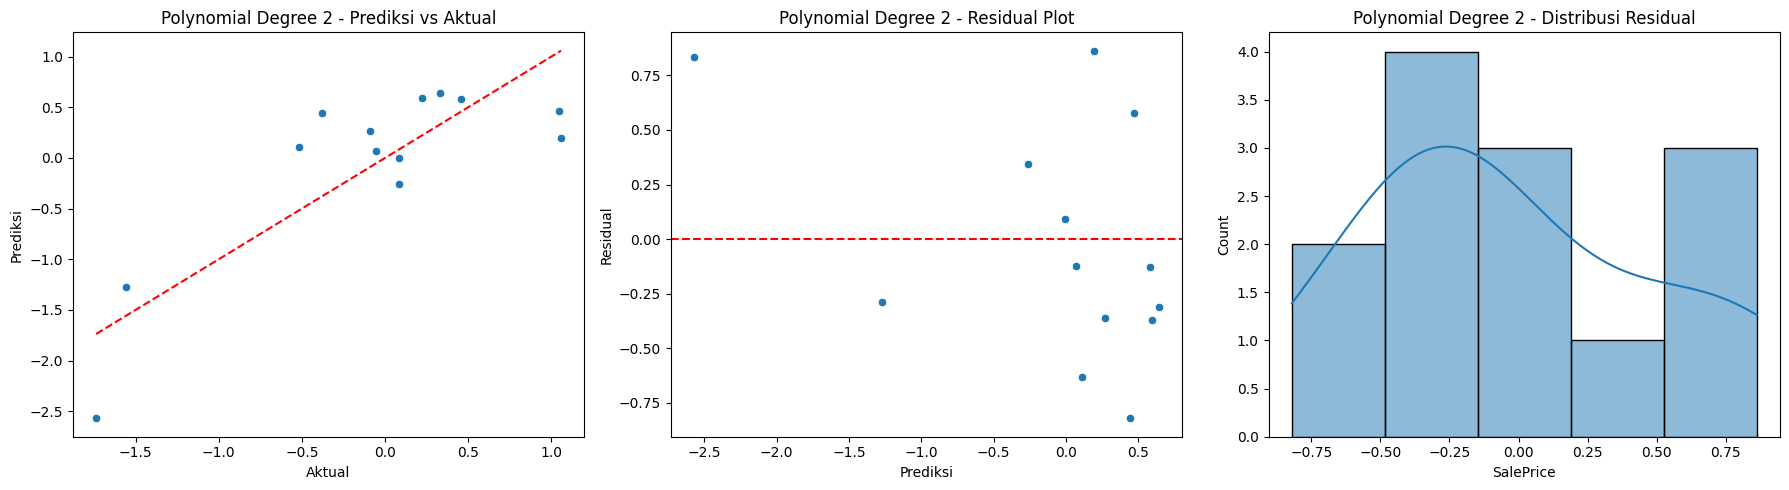


Polynomial Regression Degree 3
MSE: 0.18
R2 Score: 0.7259


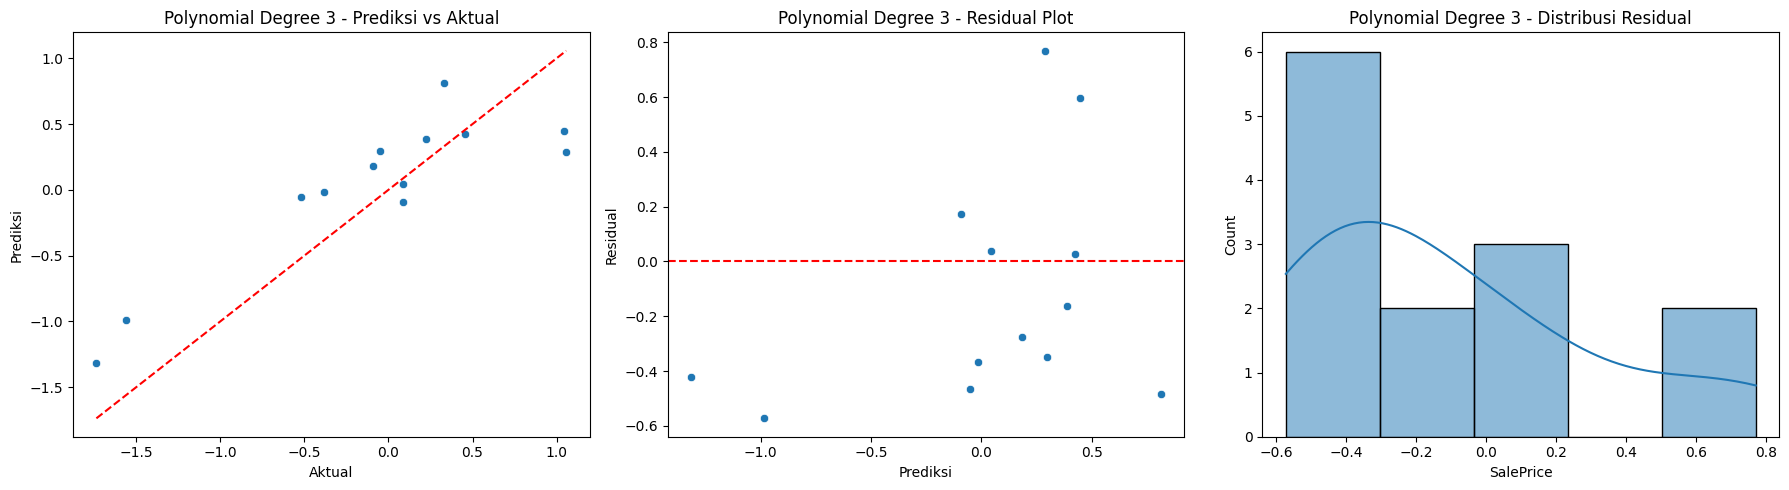

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# === 1. Load dan Preprocessing Dataset ===
df_clean = pd.read_csv("feature_scaling.csv")
df_clean_num = df_clean.select_dtypes(include=[np.number]).dropna()

X = df_clean_num.drop("SalePrice", axis=1)
y = df_clean_num["SalePrice"]

# === 2. Scaling ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 3. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === Fungsi Visualisasi + Simpan ===
def plot_and_save(y_test, y_pred, title_prefix, filename):
    residuals = y_test - y_pred

    plt.figure(figsize=(18, 5))

    # Scatter plot: Prediksi vs Aktual
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel("Aktual")
    plt.ylabel("Prediksi")
    plt.title(f"{title_prefix} - Prediksi vs Aktual")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

    # Residual plot
    plt.subplot(1, 3, 2)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Prediksi")
    plt.ylabel("Residual")
    plt.title(f"{title_prefix} - Residual Plot")

    # Distribusi residual
    plt.subplot(1, 3, 3)
    sns.histplot(residuals, kde=True)
    plt.title(f"{title_prefix} - Distribusi Residual")

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# === 4. Polynomial Regression Degree 2 ===
poly2 = PolynomialFeatures(degree=2)
X_train_poly2 = poly2.fit_transform(X_train)
X_test_poly2 = poly2.transform(X_test)

model_poly2 = LinearRegression()
model_poly2.fit(X_train_poly2, y_train)
y_pred_poly2 = model_poly2.predict(X_test_poly2)

mse_poly2 = mean_squared_error(y_test, y_pred_poly2)
r2_poly2 = r2_score(y_test, y_pred_poly2)

print("Polynomial Regression Degree 2")
print(f"MSE: {mse_poly2:.2f}")
print(f"R2 Score: {r2_poly2:.4f}")
plot_and_save(y_test, y_pred_poly2, "Polynomial Degree 2", "Polynomial_Degree_2.png")

# === 5. Polynomial Regression Degree 3 ===
poly3 = PolynomialFeatures(degree=3)
X_train_poly3 = poly3.fit_transform(X_train)
X_test_poly3 = poly3.transform(X_test)

model_poly3 = LinearRegression()
model_poly3.fit(X_train_poly3, y_train)
y_pred_poly3 = model_poly3.predict(X_test_poly3)

mse_poly3 = mean_squared_error(y_test, y_pred_poly3)
r2_poly3 = r2_score(y_test, y_pred_poly3)

print("\nPolynomial Regression Degree 3")
print(f"MSE: {mse_poly3:.2f}")
print(f"R2 Score: {r2_poly3:.4f}")
plot_and_save(y_test, y_pred_poly3, "Polynomial Degree 3", "Polynomial_Degree_3.png")

# === 6. Simpan Hasil Evaluasi ke CSV ===
hasil_poly = pd.DataFrame({
    "Model": ["Polynomial Degree 2", "Polynomial Degree 3"],
    "MSE": [mse_poly2, mse_poly3],
    "R2_Score": [r2_poly2, r2_poly3]
})
hasil_poly.to_csv("Polynomial Regression.csv", index=False)


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# === Load data yang sudah discaling dan bebas outlier ===
df_scaled = pd.read_csv("feature_scaling.csv")
df_scaled_num = df_scaled.select_dtypes(include=[np.number]).dropna()

X = df_scaled_num.drop("SalePrice", axis=1)
y = df_scaled_num["SalePrice"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Untuk menyimpan hasil evaluasi
results = []

# Fungsi visualisasi
def plot_knn_result(y_test, y_pred, k):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Aktual")
    plt.ylabel("Prediksi")
    plt.title(f"KNN Regression (K={k})\nAktual vs Prediksi")
    plt.tight_layout()
    plt.savefig(f"knn_k{k}.png")
    plt.close()

# Uji untuk nilai K = 3, 5, 7
for k in [3, 5, 7]:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Simpan hasil ke list
    results.append({
        "K": k,
        "MSE": mse,
        "R2_Score": r2
    })

    # Simpan visualisasi
    plot_knn_result(y_test, y_pred, k)

# Simpan hasil evaluasi ke CSV
df_results = pd.DataFrame(results)
df_results.to_csv("knn_results.csv", index=False)

# Print hasil di console (opsional)
print(df_results)


   K       MSE  R2_Score
0  3  0.160631  0.750645
1  5  0.166810  0.741053
2  7  0.185230  0.712459
